## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/home/morteza/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import nuclei
config = nuclei.NucleiConfig()
DATASET_DIR = "../nuclei/data"  # TODO: enter value here
STAGE='stage1'

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]
 [ 10  10]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_MIN_DIM                  400
IMAGE_PADDING                  True
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (320, 320)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING      

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")
elif config.NAME == 'nuclei':
    dataset = nuclei.NucleiDataset()
    dataset.load_nuclei(DATASET_DIR,'train',STAGE)

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

image list size: 670
Images: 670
Classes: ['BG', 'NUCLEI']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

weights_path = model.find_last()[1]
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /fast/Mask_RCNN/logs/nuclei20180128T0917/mask_rcnn_nuclei_0062.h5


## Run Detection

In [8]:
def remove_overlap(masks):
    masks = masks.copy()
    overlap_pixels = np.where(masks.sum(axis=2)>1)
    maxs = np.argmax(masks[overlap_pixels[0],overlap_pixels[1],:],axis=1)
    for i,j,z in zip(overlap_pixels[0],overlap_pixels[1],maxs):
        masks[i,j,:] = 0
        masks[i,j,z] = 1
    empty_masks = []
    for i in range(masks.shape[2]):
        if masks[:,:,i].sum() < 2:
            empty_masks.append(i)

    return np.delete(masks,empty_masks,axis=2)



In [9]:
import time

image ID: nuclei.6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 (157) [empty]
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  217.00000
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  113.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
1/1 [==============================] - 0s 310ms/step
detection time 1.3730411529541016


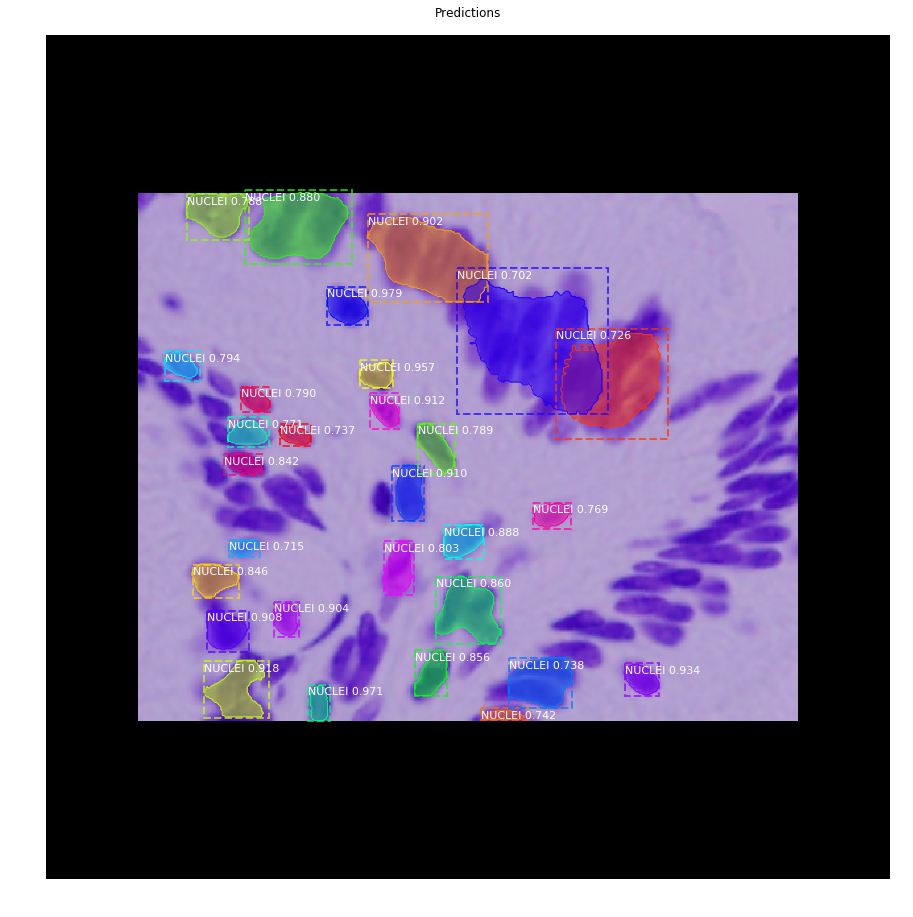

gt_class_id              shape: (111,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (111, 4)              min:   70.00000  max:  570.00000
gt_mask                  shape: (640, 640, 111)       min:    0.00000  max:    1.00000


In [13]:
start = time.time()
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False,augment=True)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
end = time.time()
r = results[0]
ax = get_ax(1)
print("detection time",end-start)
masks = remove_overlap(r['masks'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

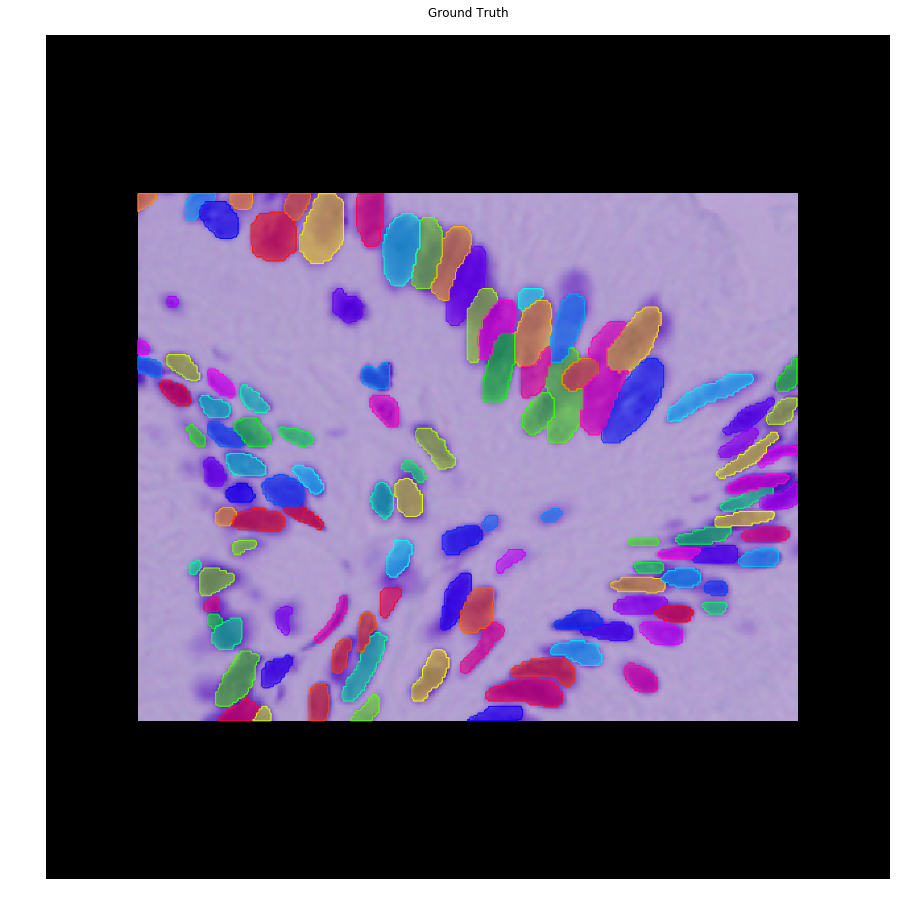

In [14]:
ax = get_ax(1)
visualize.display_image_masks(image, gt_mask, title="Ground Truth",ax=ax)

### Precision-Recall

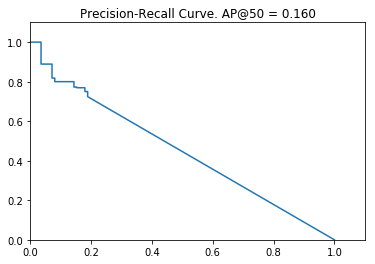

In [15]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)

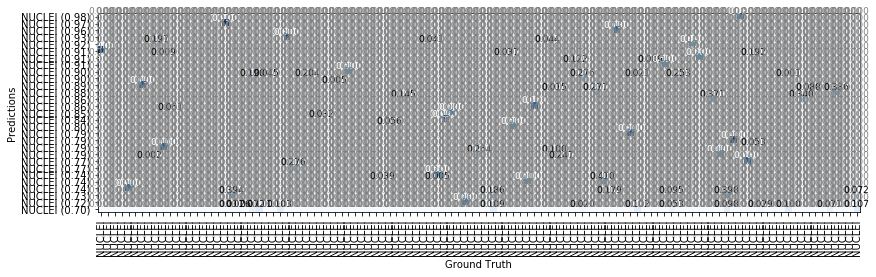

In [16]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [17]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id,
                              r['rois'], r['class_ids'], r['scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

1/1 [==============================] - 0s 316ms/step
mAP @ IoU=50:  0.6012210004166259


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [37]:
model.config.RPN_NMS_THRESHOLD = 0.6

In [38]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (102000,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (512, 4)              min:   -8.07542  max:    3.86699
positive_anchors         shape: (157, 4)              min:   45.37258  max:  571.31371
negative_anchors         shape: (355, 4)              min:  -96.00000  max:  714.50967
neutral anchors          shape: (101488, 4)           min: -181.01934  max:  789.01934
refined_anchors          shape: (157, 4)              min:   70.00000  max:  570.00000


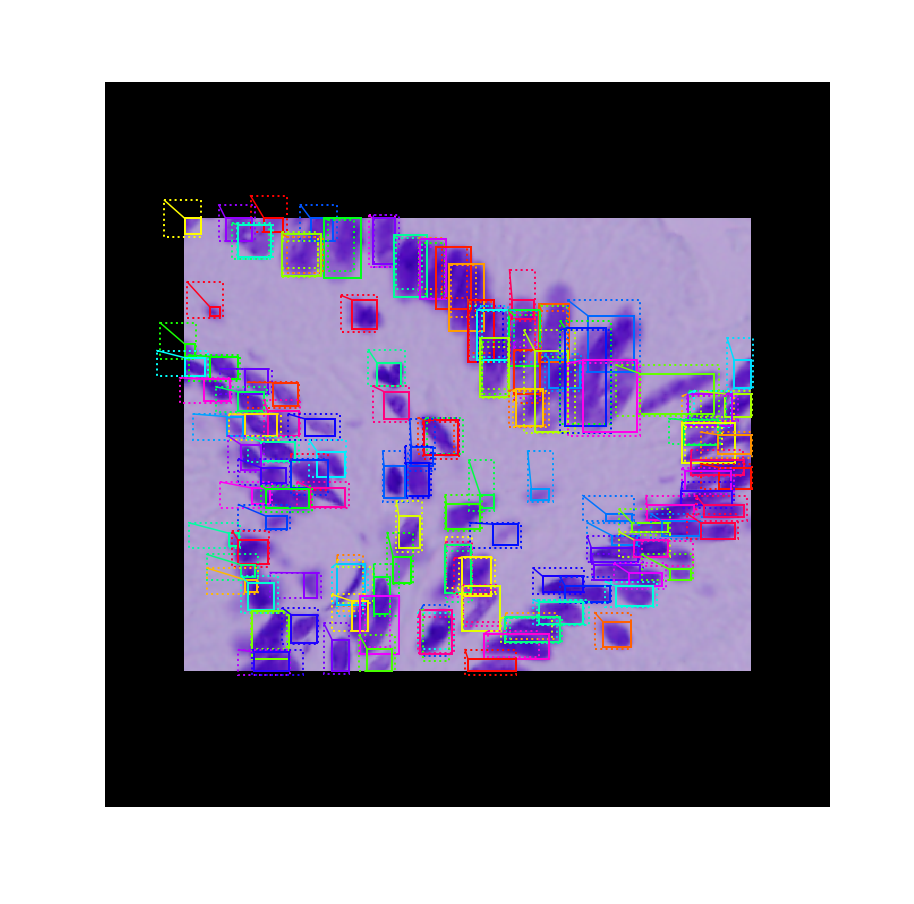

In [39]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [40]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 102300, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:   37.37258  max:  592.00000
refined_anchors          shape: (1, 6000, 4)          min:   51.67363  max:  590.42181
refined_anchors_clipped  shape: (1, 6000, 4)          min:   51.67363  max:  590.42181
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3013.00000
proposals                shape: (1, 1000, 4)          min:    0.08074  max:    0.91824


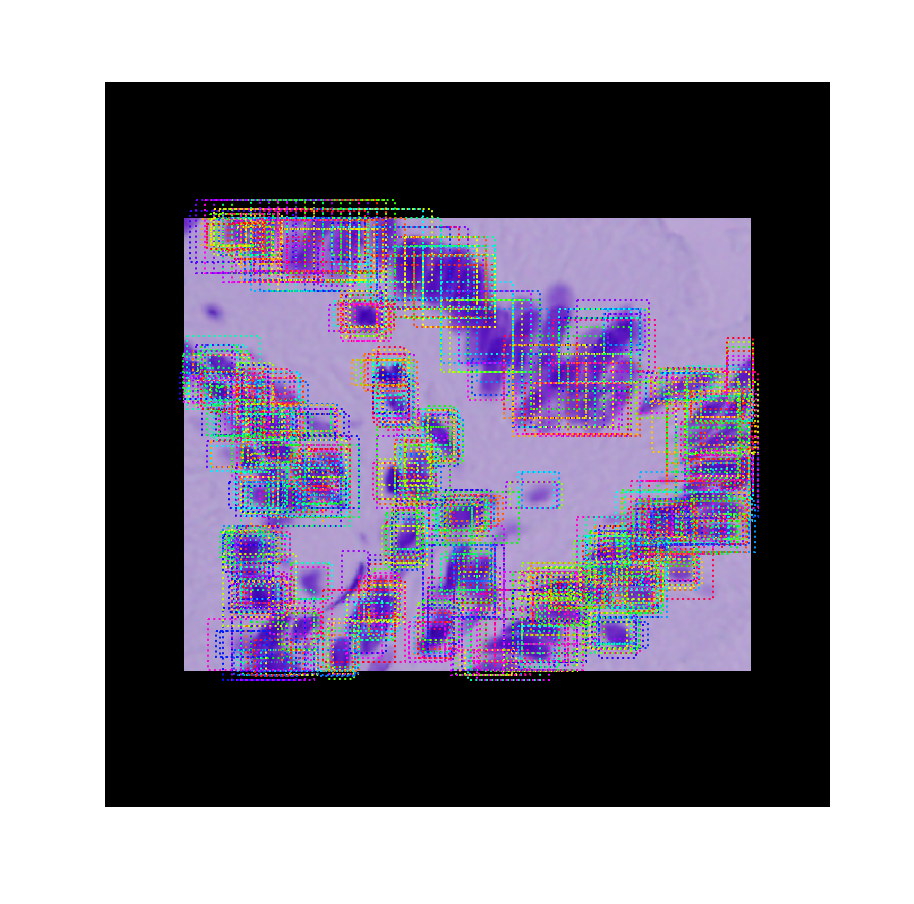

In [41]:
# Show top anchors by score (before refinement)
limit = 1000
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

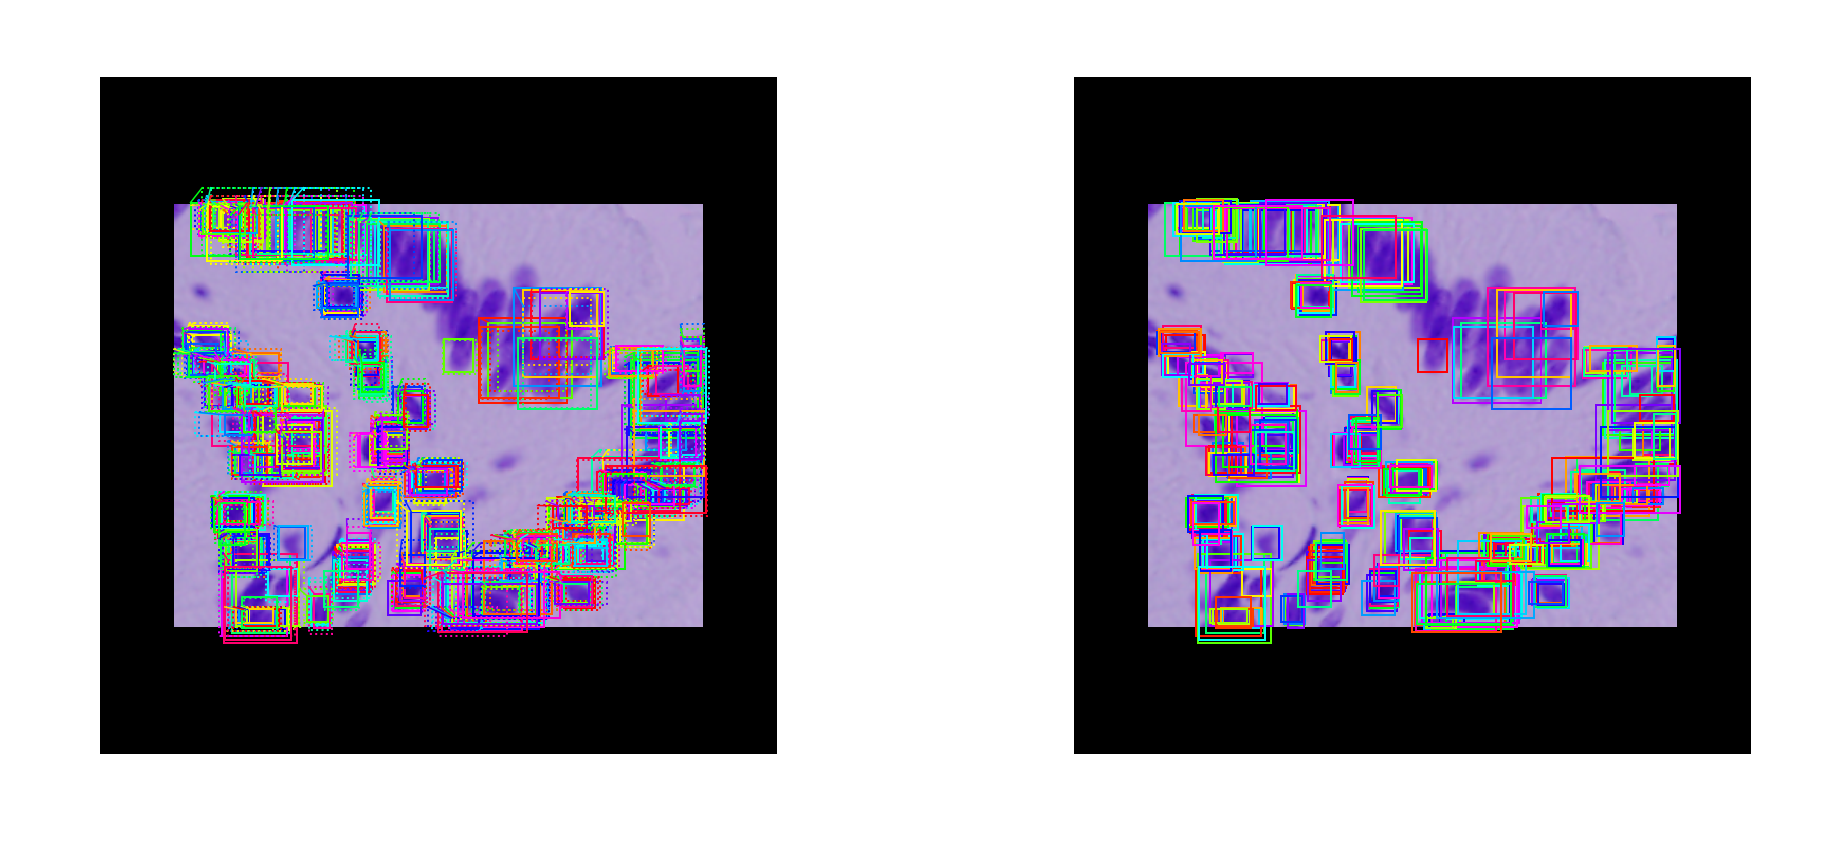

In [42]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 512
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

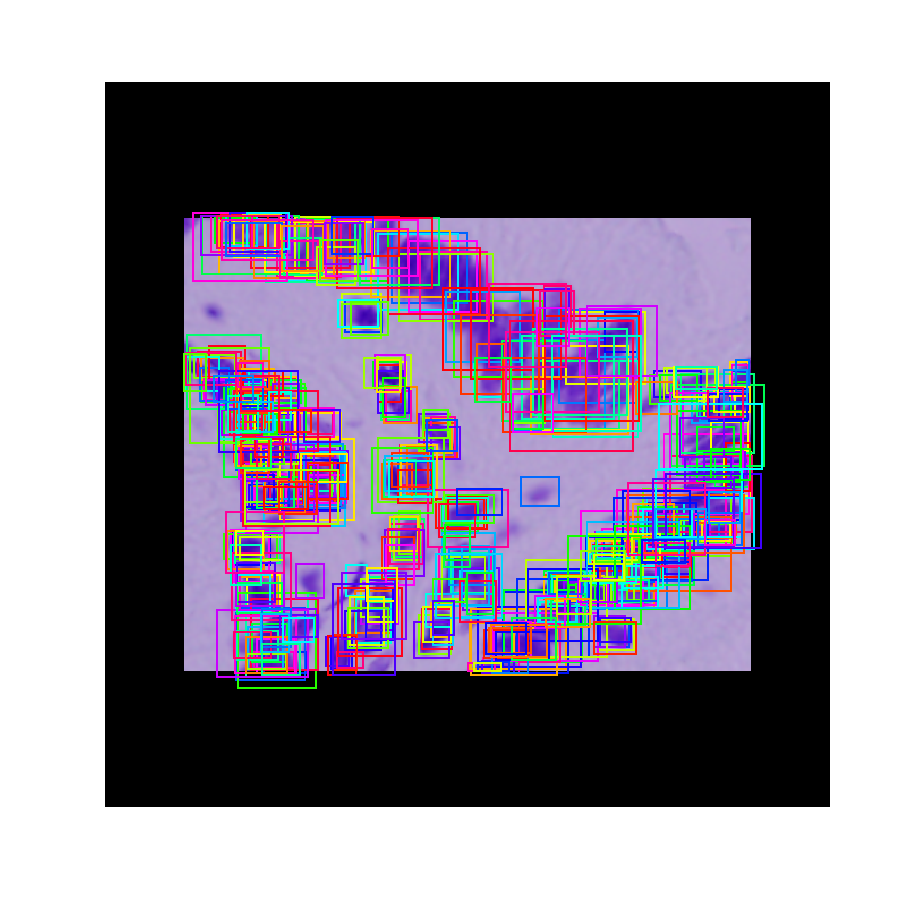

In [43]:
# Show refined anchors after non-max suppression
limit = 512
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

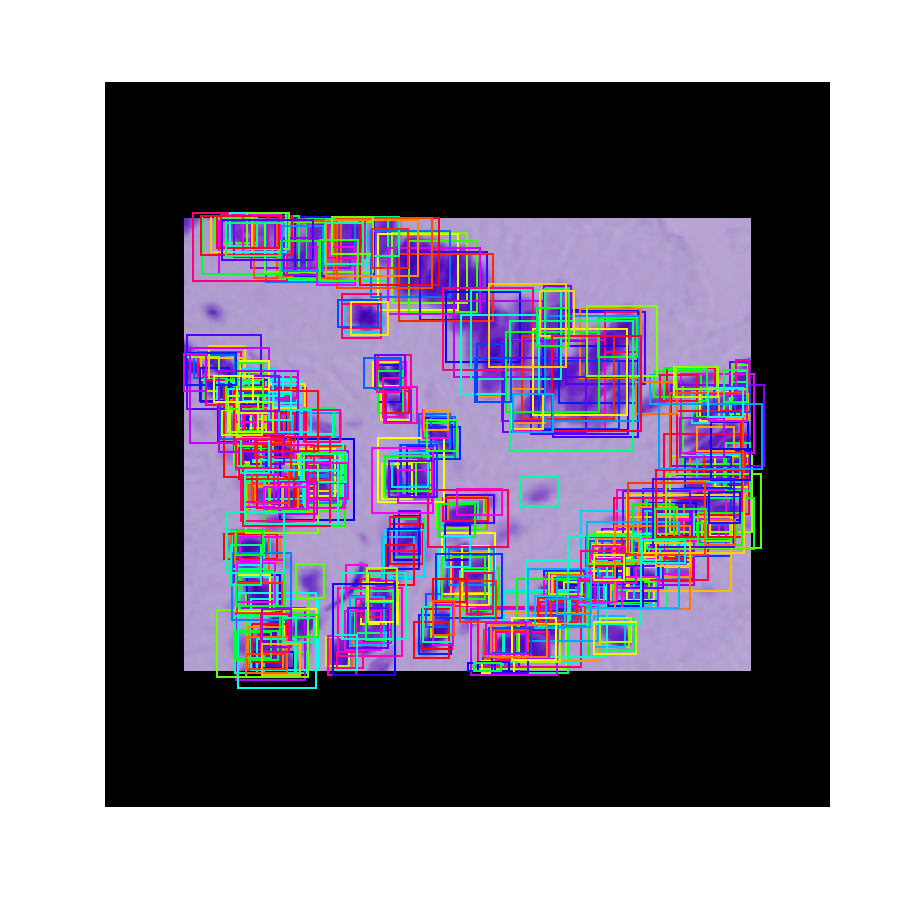

In [45]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 512
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [46]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (102000)       Recall: 0.207  Positive anchors: 69
Refined Anchors ( 6000)   Recall: 0.486  Positive anchors: 236
Post NMS Anchors (  512)  Recall: 0.225  Positive anchors: 33


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [53]:
model.config.DETECTION_MIN_CONFIDENCE = 0.5

In [54]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.08074  max:    0.91824
probs                    shape: (1, 1000, 2)          min:    0.00398  max:    0.99602
deltas                   shape: (1, 1000, 2, 4)       min:   -4.09536  max:    4.01271
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00275  max:    0.99921
detections               shape: (1, 100, 6)           min:    0.00000  max:  574.00000


52 detections: ['NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI']


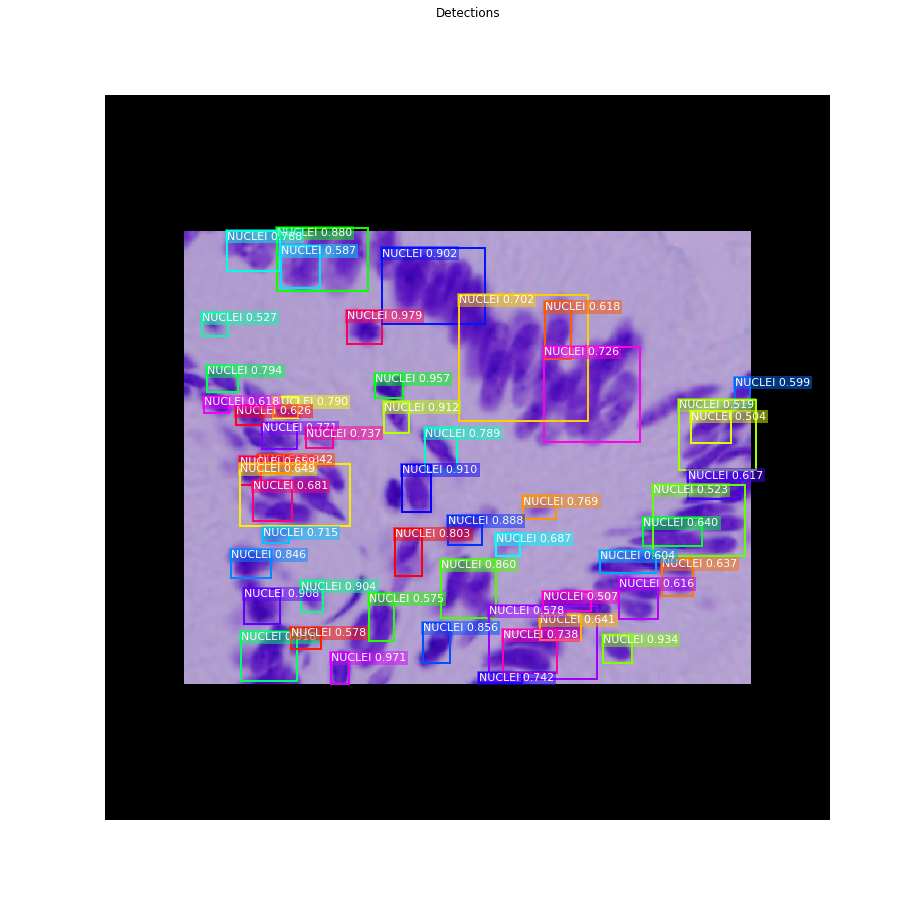

In [55]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [56]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
248 Positive ROIs
[('BG', 752), ('NUCLEI', 248)]


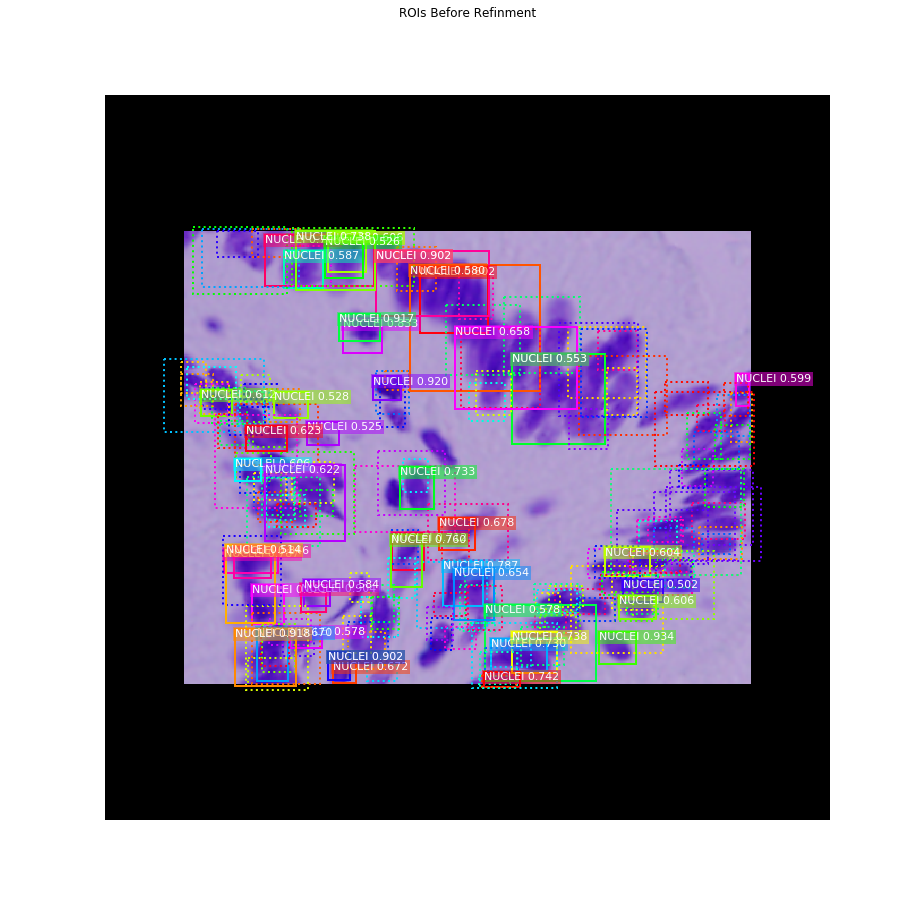

In [57]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinment",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.09536  max:    4.01271
refined_proposals        shape: (1000, 4)             min:   48.00000  max:  601.00000


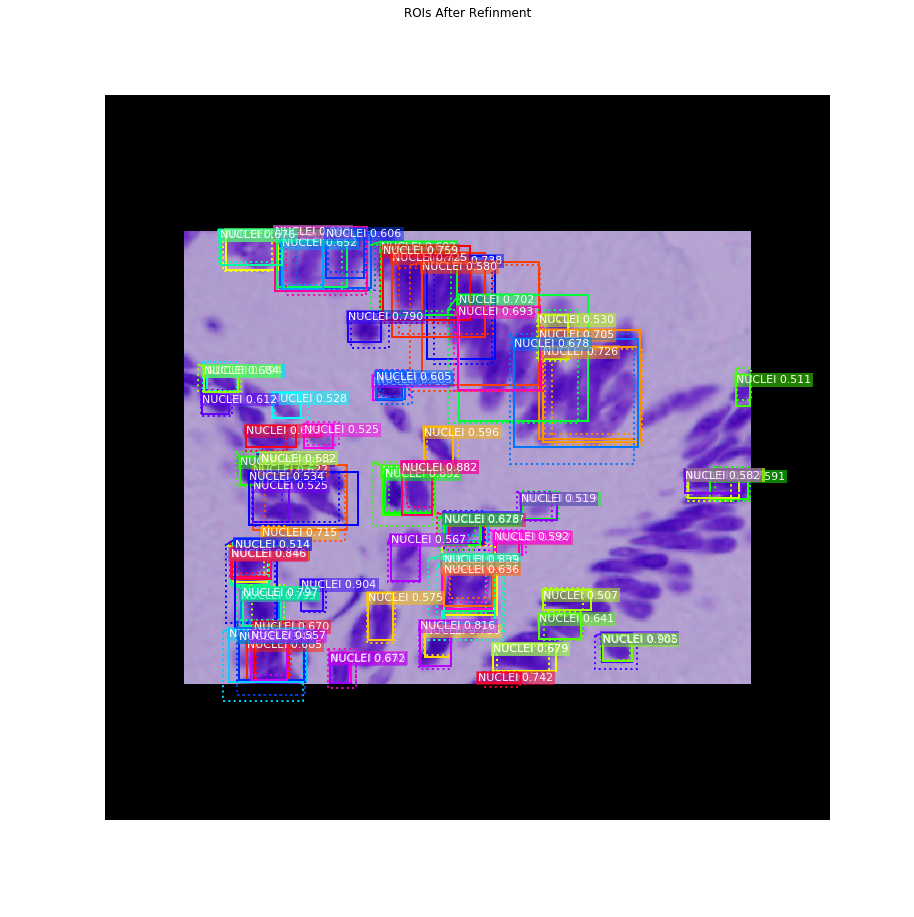

In [59]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 100
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinment",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [65]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 248 detections:
[  0   1   2   3   5   6   7   8   9  10  12  13  14  16  20  21  22  24
  27  29  30  32  35  36  38  40  41  44  46  48  51  56  59  61  64  65
  69  70  71  75  76  81  86  87  90  92  93  95  98 103 108 112 113 115
 119 120 123 127 130 131 133 137 138 144 145 147 148 151 156 157 160 166
 169 172 176 182 184 185 188 189 190 198 202 205 208 210 213 220 223 224
 228 231 232 237 239 240 244 245 247 255 256 258 259 261 267 272 273 276
 281 282 284 296 300 301 303 304 310 311 312 316 317 319 323 326 330 336
 341 346 352 353 365 368 373 380 384 389 391 394 396 406 410 416 421 422
 427 429 431 433 435 438 447 457 459 463 466 467 473 475 478 487 495 499
 502 505 506 512 514 515 518 519 521 527 544 555 556 562 563 566 573 582
 589 591 593 600 628 631 633 639 640 645 646 651 653 656 658 659 672 678
 690 694 695 696 701 716 725 744 746 752 758 760 765 766 768 770 771 776
 782 794 795 801 805 806 808 818 822 824 827 837 858 862 874 875 879 899
 903 914 923 936 946 951 954 9

In [66]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 248:
[  0   1   2   3   5   6   7   8   9  10  12  13  14  16  20  21  22  24
  27  29  30  32  35  36  38  40  41  44  46  48  51  56  59  61  64  65
  69  70  71  75  76  81  86  87  90  92  93  95  98 103 108 112 113 115
 119 120 123 127 130 131 133 137 138 144 145 147 148 151 156 157 160 166
 169 172 176 182 184 185 188 189 190 198 202 205 208 210 213 220 223 224
 228 231 232 237 239 240 244 245 247 255 256 258 259 261 267 272 273 276
 281 282 284 296 300 301 303 304 310 311 312 316 317 319 323 326 330 336
 341 346 352 353 365 368 373 380 384 389 391 394 396 406 410 416 421 422
 427 429 431 433 435 438 447 457 459 463 466 467 473 475 478 487 495 499
 502 505 506 512 514 515 518 519 521 527 544 555 556 562 563 566 573 582
 589 591 593 600 628 631 633 639 640 645 646 651 653 656 658 659 672 678
 690 694 695 696 701 716 725 744 746 752 758 760 765 766 768 770 771 776
 782 794 795 801 805 806 808 818 822 824 827 837 858 862 874 875 879 899
 903 9

#### Per-Class Non-Max Suppression

In [73]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

NUCLEI                : [  0   1   2   3   8  10  16  20  22  27  32  41  51  69  70  81  93 119
 127 131 144 202 228 244 256 267 276 296 312 319 341 394 396 421 487 502
 512 514 562 600 659 690 746 795 801 822 824 874 879 975 983 995] -> [  1  51   8  10 312  27 512  20 659 746   3   2 144 119   0 127 244 824
 396  93 879 228 874  16 502  41 487 801 822 995 514 276 600  69 690  81
  70 202 975 421 341 319 131 296 267 562 256 795 394  32  22 983]

Kept after per-class NMS: 52
[  0   1   2   3   8  10  16  20  22  27  32  41  51  69  70  81  93 119
 127 131 144 202 228 244 256 267 276 296 312 319 341 394 396 421 487 502
 512 514 562 600 659 690 746 795 801 822 824 874 879 975 983 995]


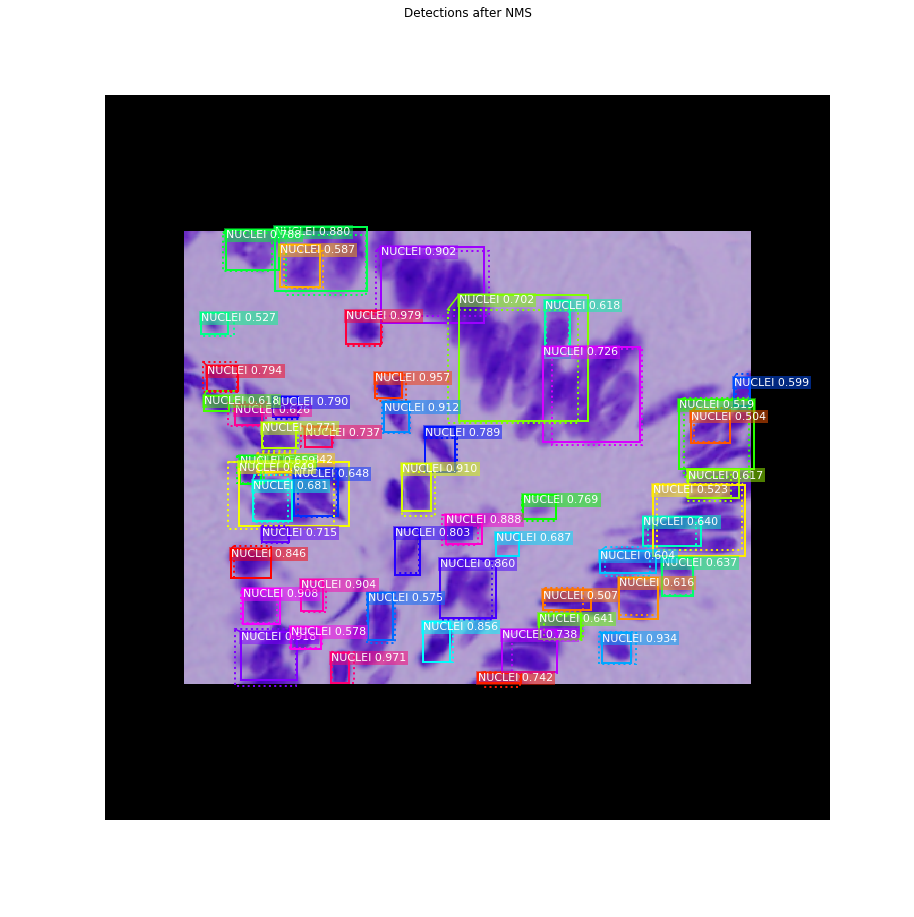

In [72]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

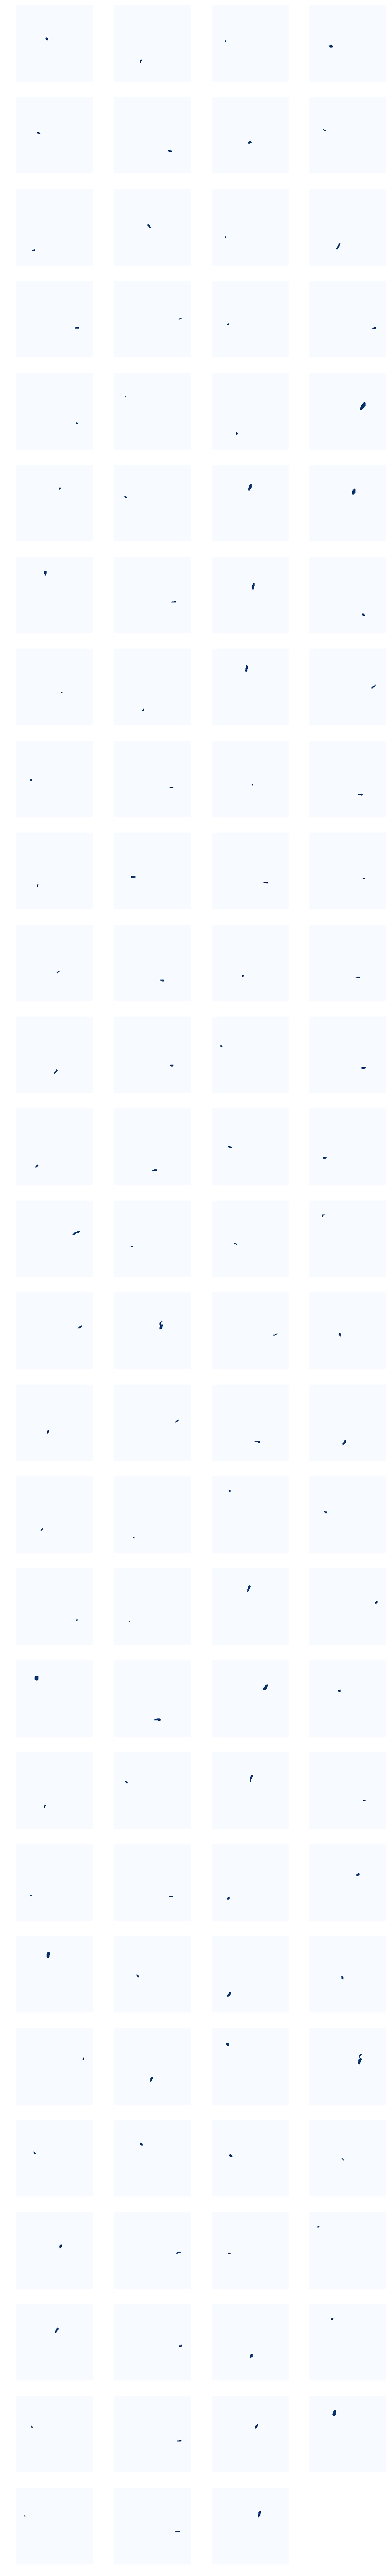

In [74]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [75]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:  574.00000
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00275  max:    0.99921
52 detections: ['NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI'
 'NUCLEI' 'NUCLEI' 'NUCLEI' 'NUCLEI']


In [76]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (52, 28, 28)          min:    0.00275  max:    0.99921
det_masks                shape: (52, 640, 640)        min:    0.00000  max:    1.00000


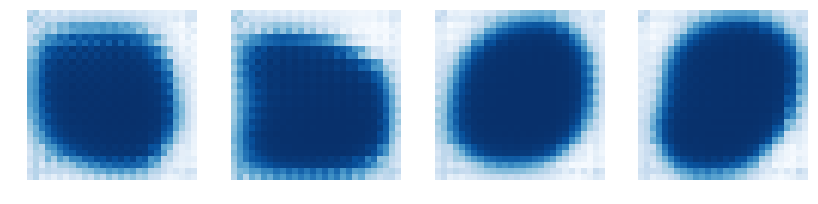

In [42]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

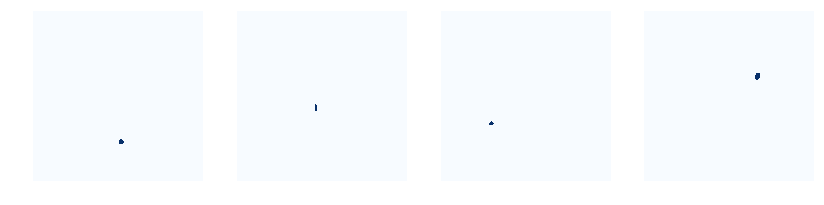

In [43]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [44]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10001
res4w_out                shape: (1, 40, 40, 1024)     min:    0.00000  max:   16.51217
rpn_bbox                 shape: (1, 102300, 4)        min:  -10.29026  max:    9.42610
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


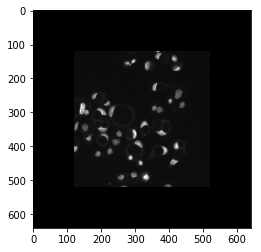

In [45]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

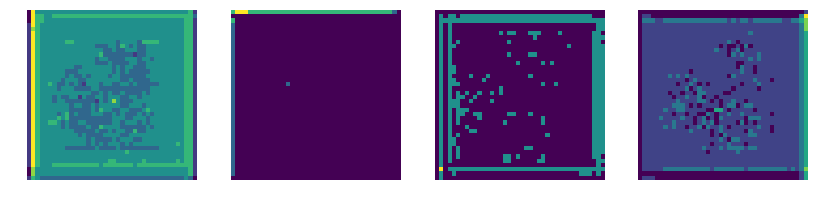

In [46]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

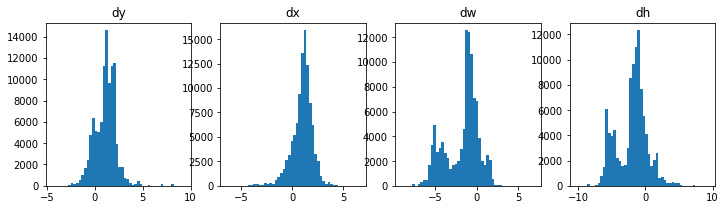

In [47]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

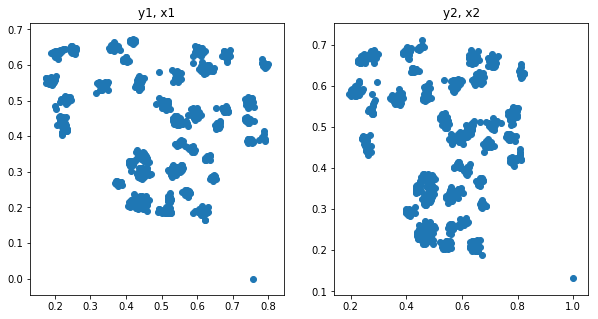

In [48]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()